In [1037]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [1038]:
#Checking wich GPU is beeing used

!nvidia-smi

Thu Nov 18 16:58:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   33C    P8    18W / 250W |   9930MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [1039]:
#Load data
data_file = 'dialogue/Dataset/VoiceDetection/Output.npy'
labels = pd.read_csv("dialogue/Dataset/VoiceDetection/boolean_labels.csv")#path to csv
labels.drop(labels.columns[[0]], axis=1, inplace=True)
data = np.load(data_file)
df_temp = pd.DataFrame()
df_data = pd.DataFrame()
#print(data)
df_data = pd.DataFrame(data)
#df_data['data'] = df_temp.values.tolist()
df_data = pd.concat([df_data, labels], axis = 1)
print(df_data.head())
np_labels = df_data['isSpeaking'].to_numpy()
np_data = data #df_data['data'].to_numpy()
#print(df_data)

            0           1           2           3           4           5  \
0    9.434201   18.539894   48.598946   23.656319   68.375114   32.585888   
1    0.988338   56.698444  196.634750  232.387924   96.131500  146.787842   
2   81.516251   74.427246  219.707489  188.375854   51.688900  133.403122   
3   51.164341   88.265450  112.086533   26.646029   34.842381   55.326729   
4  627.108093  546.499390  261.254089  252.623535  181.304245   87.163826   

            6           7           8           9  ...          5623  \
0   46.476070   36.406357   26.361317    7.968925  ...  5.381881e-07   
1   69.585159   39.243427   49.696144  143.559296  ...  3.601597e-04   
2  285.412262   55.923164   11.703285   32.941082  ...  2.799673e-04   
3   54.793144   58.523682   30.524288   49.757534  ...  6.220056e-07   
4   49.720688  104.022697  215.083267  165.247910  ...  7.153016e-07   

           5624          5625          5626          5627          5628  \
0  5.609164e-07  6.777958e-07

In [1040]:
#df_data.drop(['isSpeaking'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_labels, test_size = 0.2, random_state = 23)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
print(type(X_train))
#print(X_train)

<class 'numpy.ndarray'>


In [1041]:
#print(pd.DataFrame(X_train))
X_train = torch.from_numpy(X_train).float()
X_train = X_train.unsqueeze_(-1)
X_train = X_train.transpose(2, 0)
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
X_test = X_test.unsqueeze_(-1)
X_test = X_test.transpose(2, 0)        #torch.tensor(X_test.values)
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
X_val = X_val.unsqueeze_(-1)
X_val = X_val.transpose(2, 0)
y_val = torch.from_numpy(y_val).float()
#print(X_val.shape, X_val)
print(X_train.shape, y_train.shape)
#print(test_X.shape)
#print(X_train)


torch.Size([1, 5632, 1472]) torch.Size([1472])


In [1042]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 100, kernel_size=1, stride = 1) #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(100, 75, kernel_size=1, stride = 1) #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(75, 50, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv3_drop = nn.Dropout2d() #dropout
        
        self.fc1 = nn.Linear(50, 36) #Fully-connected classifier layer
        self.fc2 = nn.Linear(36, 54) #Fully-connected classifier layer
        self.fc3 = nn.Linear(54, 19) #Fully-connected classifier layer
        self.fc4 = nn.Linear(19,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 1))
        x = F.relu(F.max_pool1d(self.conv2(x), 1))
        x = F.relu(F.max_pool1d(self.conv3_drop(self.conv3(x)), 1))
        
        #point A
        x = x.transpose(1, 2)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return torch.sigmoid(self.fc4(x))
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],kernel_size = 10)

In [1043]:
weight = torch.FloatTensor([1])
criterion = nn.L1Loss()
optimizer = optim.Adam(CNN.parameters(), lr=0.0003)

In [1044]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

In [1045]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [1046]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test', 'test_loss', 'train_loss'])
    
for epoch in range(250):
        y_pred = CNN(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        if epoch % 1 == 0:
        
            train_acc = calculate_accuracy(y_train, CNN.post_forward(y_pred))
        
            y_test_pred = CNN(X_test)

            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, CNN.post_forward(y_test_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc), 'test_loss': round_tensor(test_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        optimizer.zero_grad()
    
        train_loss.backward()
    
        optimizer.step()


epoch 0
Train set - loss: 0.504, accuracy: 0.49
Test  set - loss: 0.503, accuracy: 0.48

epoch 1
Train set - loss: 0.501, accuracy: 0.499
Test  set - loss: 0.499, accuracy: 0.498

epoch 2
Train set - loss: 0.495, accuracy: 0.537
Test  set - loss: 0.5, accuracy: 0.522

epoch 3
Train set - loss: 0.5, accuracy: 0.516
Test  set - loss: 0.498, accuracy: 0.539

epoch 4
Train set - loss: 0.495, accuracy: 0.53
Test  set - loss: 0.498, accuracy: 0.524

epoch 5
Train set - loss: 0.496, accuracy: 0.546
Test  set - loss: 0.497, accuracy: 0.515

epoch 6
Train set - loss: 0.497, accuracy: 0.542
Test  set - loss: 0.496, accuracy: 0.535

epoch 7
Train set - loss: 0.493, accuracy: 0.555
Test  set - loss: 0.498, accuracy: 0.509

epoch 8
Train set - loss: 0.489, accuracy: 0.583
Test  set - loss: 0.498, accuracy: 0.53

epoch 9
Train set - loss: 0.488, accuracy: 0.586
Test  set - loss: 0.491, accuracy: 0.541

epoch 10
Train set - loss: 0.482, accuracy: 0.588
Test  set - loss: 0.493, accuracy: 0.55

epoch 1

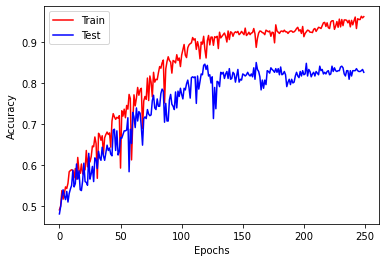

     Epoch  Acc_train  Acc_test  test_loss  train_loss
0      0.0      0.490     0.480      0.503       0.504
1      1.0      0.499     0.498      0.499       0.501
2      2.0      0.537     0.522      0.500       0.495
3      3.0      0.516     0.539      0.498       0.500
4      4.0      0.530     0.524      0.498       0.495
..     ...        ...       ...        ...         ...
245  245.0      0.955     0.828      0.193       0.065
246  246.0      0.955     0.828      0.197       0.065
247  247.0      0.963     0.830      0.190       0.078
248  248.0      0.959     0.833      0.191       0.057
249  249.0      0.962     0.826      0.205       0.061

[250 rows x 5 columns]


In [1047]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

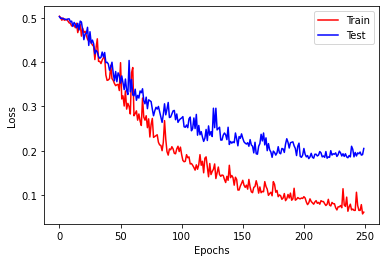

In [1048]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.test_loss,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [1049]:
classes = ['No Voice', 'Voice']
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.87      0.79      0.83       241
       Voice       0.79      0.87      0.83       219

    accuracy                           0.83       460
   macro avg       0.83      0.83      0.83       460
weighted avg       0.83      0.83      0.83       460



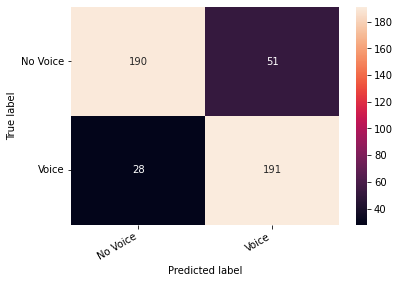

In [1050]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [1051]:
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.87      0.80      0.83       211
       Voice       0.76      0.83      0.79       157

    accuracy                           0.82       368
   macro avg       0.81      0.82      0.81       368
weighted avg       0.82      0.82      0.82       368



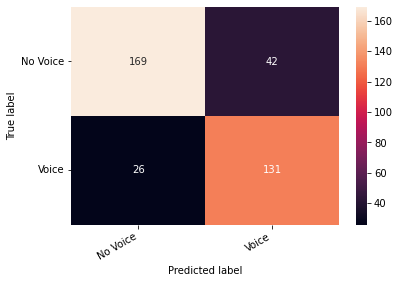

In [1052]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [1053]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
